***
# Imports
### <span style="color: red;">NB. Used Python 3.10.6 kernel</span>
### <span style="color: red;">run command in root of this folder:</span> make install_requirements 

In [1]:
import os
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
import dask.dataframe as dd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  

%pip install seaborn # no seaborn by default in AWS SageMaker
import seaborn as sns
            # sklearn techniques
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils import shuffle
            # sklearn models
from sklearn.linear_model import LinearRegression, LogisticRegression

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

In [3]:
# NOTE_BENE:
# Search for: 
# ASSUMPTION
# to find assumptions made during EDA

***
# Set environment to run some cells but not others - otherwise causes errors and gets stuck:

In [4]:
# environment_running = "sagemaker"
environment_running = "laptop"
key = 'HOME'
value = os.getenv(key) 
print(f"{value}")
import sys
print(f"{sys.platform}")


/home/hughharford
linux


***
# Sourcing data and handling it

In [5]:
# run this cell to retrieve data and place in the correct location for the below
# obviously, a login will be needed, or kaggle authentication in environment variable
retrieve_data = 0
if retrieve_data:
    !cd /raw_data/
    !kaggle datasets download -d ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting
    
# alternatively:
# download to the raw_data folder from the following url
dataset_url = 'https://www.kaggle.com/datasets/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting?select=all_tournaments.csv'

In [6]:
# check raw data archive path extant:
atp_data_path = os.path.join('..','raw_data','archive')
assert os.path.exists(atp_data_path)

# set read_data path for chunking later on:
read_data_path = os.path.join('..','raw_data','read_data')
assert os.path.exists(read_data_path) 

In [7]:
# unzip archive, if not already done

# confirm .csv files x 7 are there:
assert os.path.isfile('../raw_data/archive/all_matches.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/all_players.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/all_tournaments.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_moneyline.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_spreads.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_totals.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/countries.csv'), 'all_matches.csv not found. download from url above'


In [8]:
# check initial data file expected are extant:
matches_data_path_full = os.path.join(atp_data_path, 'all_matches.csv')
assert os.path.exists(matches_data_path_full)

In [9]:
# this works to convert dates as reading in. good news
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None) #.astype(schema)

/tmp/ipykernel_30476/2325152176.py:3: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None) #.astype(schema)


In [10]:
## needs care here, too big for memory 
## was using nrows=50_000
# matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None)

matches_df_1st_50k.tail()

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
49995,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen,NaN,pablo-figueroa,...,NaN,NaN,f,f,2.0,f,f,25,3,DEN
49996,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andrea-arnaboldi_nicolas-tourte,...,NaN,NaN,t,f,NaN,t,t,25,7,DEN
49997,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andreas-siljestrom_oskar-pallin,...,NaN,NaN,t,f,NaN,t,t,25,6,DEN
49998,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,antti-tuomi_niklas-bucht,...,NaN,NaN,t,f,NaN,t,t,25,4,DEN
49999,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,jacob-melskens_tore-deleuran-skjold,...,NaN,NaN,t,f,NaN,t,t,25,5,DEN


In [11]:
# trying full dataset on AWS sagemaker to see what happens:
if environment_running == "sagemaker":
    matches_df = pd.read_csv(matches_data_path_full, index_col=None).astype(schema)
    matches_df.tail()

In [12]:
matches_data_path = os.path.join(atp_data_path, 'all_matches_1st50k.csv')
# confirm file is there:
assert os.path.exists(matches_data_path)
# if you get an error here, rerun the cell above with 'save_csv_back_out = 1'
sample_df_path = os.path.join('..','raw_data','atp_sample.csv')
assert os.path.exists(matches_data_path)
# if you get an error here, rerun the 2 cells below title: "Get first sample of the full dataset to ease usage"

In [13]:
# save a sample so we can establish working without using the whole dataset:
save_csv_back_out = 0
if save_csv_back_out:
    matches_df_1st_50k.to_csv(matches_data_path)

In [14]:
# KEEP FOR LATER
# not using until we work on the data and save it out in stages:

# matches_data_path_latest = os.path.join(atp_data_path, 'all_matches_1st50k_latest.csv')
# assert os.path.exists(matches_data_path_latest)

***
# First EDA (Exploratory Data Analysis)

#### NOTE: see cell below title:
Start to get a little organised per column
####       run this cell before some of the below to reset various counts etc.

In [16]:
# this gets stuck, hence: 'run_difficult_cell'
run_difficult_cell = 0
if run_difficult_cell:
    matches_data_latest = pd.read_csv(matches_data_path_full, index_col=None)

### Notes:
- It became clear above that loading the 4.3m rows into pandas cannot
be handled by this machine
- Could use the cloud - and will try later, but initially let's try with
these limited resources, it's good practice.

### Notes on progress:
- dates for start_date & end_date - relatively easy to do



In [ ]:
# revert to using Dataframe above, suffices for now
matches_df_1st_50k.info() 
# 50_000 rows is <21mb in memory

In [18]:
# first look at columns 
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

In [19]:
# there are a bunch of columns we can avoid using, certainly initially
# looking at the datatypes, there is probably a lot of room for memory reduction

In [20]:
# NOTE from Pandas: columns 5, 8, 10, 45, 48 have mixed datatypes:
mixed_datatypes = ['currency', 'player_name', 'opponent_name', 'duration', 'seed']
# let's see:
print(matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].head())

  currency   player_name  opponent_name  duration seed
0        €      A. Partl      A. Martin  01:02:00  NaN
1        €      A. Partl     J. Kovalik  02:43:00  NaN
2        €    A. Velotti      D. Hrbaty  01:17:00  NaN
3        €           NaN            NaN       NaN  NaN
4        €  A. Giannessi  H. Heliovaara  02:32:00    1


In [21]:
matches_df_1st_50k.value_counts()

start_date  end_date    location                                              court_surface  prize_money  currency  year  player_id              player_name       opponent_id             opponent_name    tournament               round                 num_sets  sets_won  games_won  games_against  tiebreaks_won  tiebreaks_total  serve_rating  aces  double_faults  first_serve_made  first_serve_attempted  first_serve_points_made  first_serve_points_attempted  second_serve_points_made  second_serve_points_attempted  break_points_saved  break_points_against  service_games_won  return_rating  first_serve_return_points_made  first_serve_return_points_attempted  second_serve_return_points_made  second_serve_return_points_attempted  break_points_made  break_points_attempted  return_games_played  service_points_won  service_points_attempted  return_points_won  return_points_attempted  total_points_won  total_points  duration  player_victory  retirement  seed  won_first_set  doubles  masters  roun

In [22]:
matches_df_1st_50k.describe()

,prize_money,year,num_sets,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating,aces,...,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,masters,round_num
count,1.553700e+04,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,10298.000000,10298.000000,...,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,50000.000000,50000.000000
mean,3.796909e+06,2006.594400,2.313920,1.15450,10.854560,10.85390,0.128100,0.256260,261.542435,5.526122,...,6.470188,11.608662,46.852301,74.486696,27.634007,74.481841,74.486308,148.968538,274.302000,2.649080
std,6.579064e+06,12.810598,0.627138,0.95365,5.432237,5.43239,0.359128,0.506395,40.758831,4.816104,...,4.155581,3.547386,16.840465,25.307795,11.281841,25.308832,25.697776,48.842251,542.212359,1.979033
min,1.060000e+04,1950.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-2.000000
25%,1.500000e+05,2000.000000,2.000000,0.00000,7.000000,7.00000,0.000000,0.000000,236.000000,2.000000,...,3.000000,9.000000,35.000000,56.000000,20.000000,56.000000,57.000000,112.000000,25.000000,1.000000
50%,6.427500e+05,2010.000000,2.000000,1.00000,12.000000,12.00000,0.000000,0.000000,265.000000,4.000000,...,6.000000,11.000000,44.000000,70.000000,27.000000,70.000000,71.000000,140.000000,25.000000,3.000000
75%,3.826655e+06,2015.000000,3.000000,2.00000,13.000000,13.00000,0.000000,0.000000,291.000000,8.000000,...,9.000000,14.000000,57.000000,91.000000,34.000000,91.000000,91.000000,181.000000,250.000000,4.000000
max,2.509600e+07,2018.000000,5.000000,4.00000,126.000000,126.00000,3.000000,3.000000,376.000000,53.000000,...,30.000000,34.000000,154.000000,225.000000,91.000000,225.000000,215.000000,420.000000,2000.000000,7.000000


In [23]:
print(f'player_name: {matches_df_1st_50k.player_name.count()} and player_id: {matches_df_1st_50k.player_id.count()}')
print(f'player_name: {matches_df_1st_50k.opponent_name.count()} and player_id: {matches_df_1st_50k.opponent_id.count()}')
# seems low ~20% of data

player_name: 10298 and player_id: 50000
player_name: 10298 and player_id: 50000


***
# Memory check cells
## Usually by column

In [24]:
matches_df_1st_50k.end_date.memory_usage() # raw as imported: 400128

400128

*** 
# Start to get a little organised per column

In [126]:
# keep a simple dict of columns to see how full they are
# could use a simple .count() but going to run across mutiple chunks, and only want to see specific columns
check_completeness = {'start_date': 0, 'end_date': 0, 'player_name': 0, 
                      'duration': 0
                      }

check_completeness_NAs = {'start_date': 0, 'end_date': 0, 'player_name': 0, 
                      'duration': 0
                      }

check_key_distinguishing_columns = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0,}

check_key_distinguishing_columns_NAs = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0,}

check_numerical_columns = {'prize_money': 0,'sets_won': 0,'games_won': 0,  
                           'games_against': 0, 'tiebreaks_won': 0,  'tiebreaks_total': 0,
                      'serve_rating': 0, 'aces': 0, 
                      'double_faults': 0, 'first_serve_made': 0, 
                      'first_serve_attempted': 0, 'first_serve_points_made': 0,  
                      'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                      'second_serve_points_attempted': 0, 'break_points_saved': 0, 
                      'break_points_against': 0, 'service_games_won': 0, 
                      'return_rating': 0, 'first_serve_return_points_made': 0, 
                      'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                      'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                      'break_points_attempted': 0, 'return_games_played': 0, 
                      'service_points_won': 0, 'service_points_attempted': 0, 
                      'return_points_won': 0, 'return_points_attempted': 0, 
                      'total_points_won': 0, 'total_points': 0, 
                      'duration': 0, 
                      # distinguishing column:
                      'round_num': 0
                      }

check_numerical_columns_NAs = {'prize_money': 0,'sets_won': 0,'games_won': 0,  
                           'games_against': 0, 'tiebreaks_won': 0,  'tiebreaks_total': 0,
                      'serve_rating': 0, 'aces': 0, 
                      'double_faults': 0, 'first_serve_made': 0, 
                      'first_serve_attempted': 0, 'first_serve_points_made': 0,  
                      'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                      'second_serve_points_attempted': 0, 'break_points_saved': 0, 
                      'break_points_against': 0, 'service_games_won': 0, 
                      'return_rating': 0, 'first_serve_return_points_made': 0, 
                      'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                      'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                      'break_points_attempted': 0, 'return_games_played': 0, 
                      'service_points_won': 0, 'service_points_attempted': 0, 
                      'return_points_won': 0, 'return_points_attempted': 0, 
                      'total_points_won': 0, 'total_points': 0, 
                      'duration': 0, 
                      # distinguishing column:
                      'round_num': 0
                      }

check_mixed_columns = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0}

check_mixed_columns_NAs = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0}

check_boolean_columns = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0}

check_boolean_columns_NAs = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0}

single_date_query = {"start_date > 2010": 0}
single_year_query = {"year > 2010": 0}


na_checks = {'seed': 0, 'serve_rating': 0, 'aces': 0, 
             'double_faults': 0, 'first_serve_made': 0, 
             'first_serve_attempted': 0, 'first_serve_points_made': 0, }
# round((matches_df_1st_50k.seed.isna().sum()/50_000)*100,2)

# # list(check_completeness.keys())
# for i in check_completeness:
#     print(i)

In [124]:
list(single_date_query.keys())[0]

'start_date > 2010'

In [82]:
# in the first 50_000 rows, column counts for these columns gives: 
for i in check_completeness.keys():
    count = matches_df_1st_50k[i].count()
    check_completeness[i] += count

In [27]:
print(check_completeness)

{'start_date': 50000, 'end_date': 48967, 'player_name': 10298, 'duration': 10298}


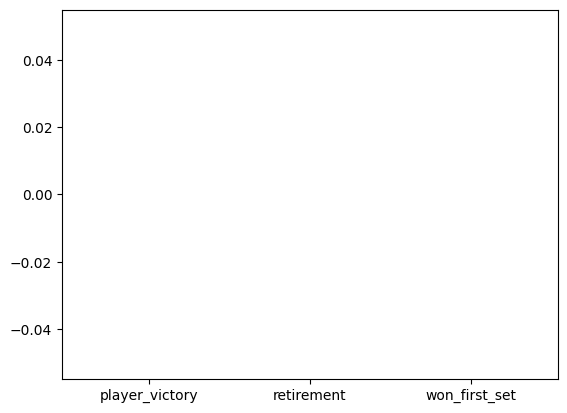

In [28]:
D = check_boolean_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

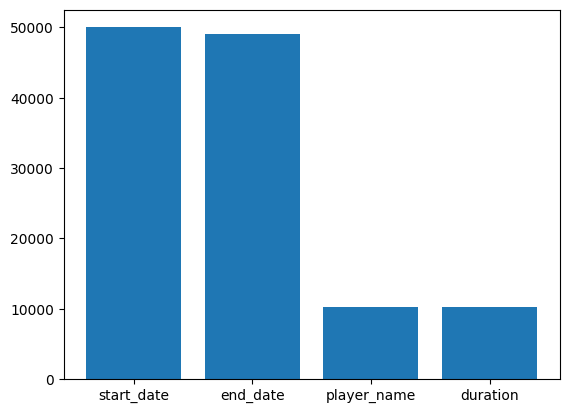

In [29]:
D = check_completeness
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [30]:
for i in check_boolean_columns:
    count = matches_df_1st_50k[i].count()
    check_boolean_columns[i] += count

In [31]:
print(check_boolean_columns)

{'player_victory': 50000, 'retirement': 50000, 'won_first_set': 49301}


In [32]:
for i in check_mixed_columns:
    count = matches_df_1st_50k[i].count()
    check_mixed_columns[i] += count

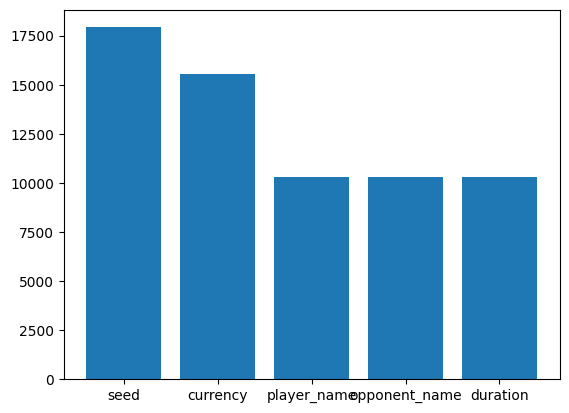

In [33]:
D = check_mixed_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

***
# INTERESTING THOUGHT:
## What is required to run the:
## a) naive model as a baseline
## b) first actual model, e.g. multivariate logistic classification?
***

***
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Sorting data column by column or by datatype

### Dates (sorted enough)

In [34]:
# This fixes the initial difficulty. not hard.
#                           HERE --v
# schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
# matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=0).astype(schema)

In [35]:
matches_df_1st_50k.dtypes.head()

start_date       datetime64[ns]
end_date         datetime64[ns]
location                 object
court_surface            object
prize_money             float64
dtype: object

In [36]:
## this caused errors on the Sagemaker Runtime:
# matches_df_1st_50k.end_date = matches_df_1st_50k.end_date.astype(dtype=np.datetime64)
# matches_df_1st_50k.start_date = matches_df_1st_50k.start_date.astype(dtype=np.datetime64)

In [37]:
matches_df_1st_50k.end_date[1] # happy enough with this being super accurate

Timestamp('2012-06-17 00:00:00')

In [38]:
matches_df_1st_50k.end_date.memory_usage()
# object and np.datetime(ns) memory the same: 400128

400128

In [39]:
print(f'oldest date: {matches_df_1st_50k.start_date.min()} and most recent: {matches_df_1st_50k.start_date.max()}')
# Interesting to see the 1950's represented

oldest date: 1950-08-25 00:00:00 and most recent: 2018-08-13 00:00:00


In [40]:
# Let's see the count per year or decade

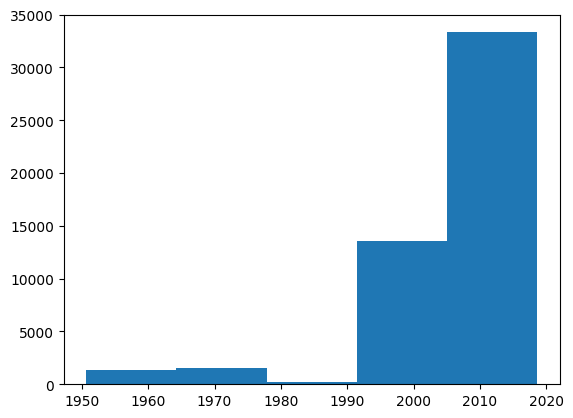

In [41]:
plt.hist(matches_df_1st_50k.start_date,bins=5); # by decade

# for both by year and by decade, it's clear that the whole dataset will be 
# needed - cannot tell yet how the whole dataset is distributed by date 

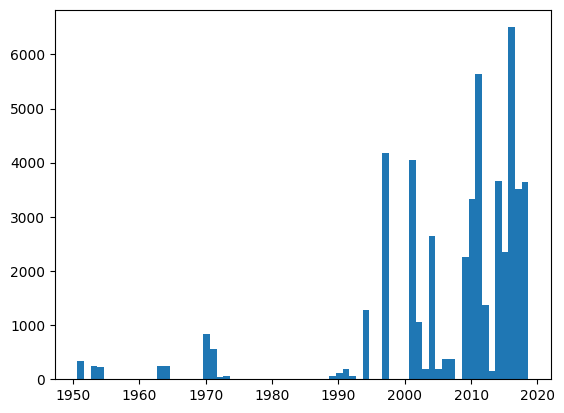

In [42]:
plt.hist(matches_df_1st_50k.start_date,bins=68); # by year
# Again, this is an interesting picture.
# Prompts question about number of tennis events per year, and similar
# And there seems to be a gap in the data around 2015 or something

In [43]:
print(f"NAs? in start_date: {pd.isna(matches_df_1st_50k.start_date).sum()}")
print(f"NAs? in end_date: {pd.isna(matches_df_1st_50k.end_date).sum()}")

NAs? in start_date: 0
NAs? in end_date: 1033


### ASSUMPTION: that end_date having 1033 na's reflects something about matches
- can't tell what yet: maybe cancelled match, or player retires before starting etc


***
# Mixed columns
These need to be sorted through, see 'check_mixed_columns'

In [44]:
print(check_mixed_columns)

{'seed': 17926, 'currency': 15537, 'player_name': 10298, 'opponent_name': 10298, 'duration': 10298}


In [45]:
matches_df_1st_50k[check_mixed_columns.keys()].head()


,seed,currency,player_name,opponent_name,duration
0,NaN,€,A. Partl,A. Martin,01:02:00
1,NaN,€,A. Partl,J. Kovalik,02:43:00
2,NaN,€,A. Velotti,D. Hrbaty,01:17:00
3,NaN,€,NaN,NaN,NaN
4,1,€,A. Giannessi,H. Heliovaara,02:32:00


In [46]:
print(f"% of NA in seed: {round((matches_df_1st_50k.seed.isna().sum()/50_000)*100,2)}")
# 64% seems fairly reasonable: more data for seeded players as likley in more matches, but lots of unseeded players in qualifying etc.
#
# Does pose the question of what to do with NAs in the immediate term. 
#
# Initial idea:
#              Impute them to 0 - i.e. 0 == not seeded

% of NA in seed: 64.15


In [47]:
print(f"% of NA in currency: {round((matches_df_1st_50k.currency.isna().sum()/50_000)*100,2)}")
# again, interesting...

% of NA in currency: 68.93


In [48]:
print(f"% of NA in player_name: {round((matches_df_1st_50k.player_name.isna().sum()/50_000)*100,2)}")
# player_name and opponent_name will be dropped, as actual identity isn't important, 
# and the matches for player_id can be found in the accompanying all_players.csv data/table

% of NA in player_name: 79.4


In [49]:
# quick check that the majority of players can be found in all_players.csv:
all_players_df = pd.read_csv('../raw_data/archive/all_players.csv')
# all_players_df # has 314483 rows...

In [50]:
print(f"all_players NAs: {all_players_df.player_id.isna().sum()}, encouraging. \nAnd length: {all_players_df.shape[0]}")

all_players NAs: 0, encouraging. 
And length: 314483


In [51]:
run_expensive_cell = 0 
if run_expensive_cell:
    print(f"Initial length player_name: {len(matches_df_1st_50k.player_name)}")
    print(f"Initial player_name NAs: {matches_df_1st_50k.player_name.isna().sum()}\n")

    inner_first50k_with_all_players_df =  matches_df_1st_50k.merge(all_players_df, how="inner", on=['player_id'])
    right_first50k_with_all_players_df =  matches_df_1st_50k.merge(all_players_df, how="right", on=['player_id'])
    left_first50k_with_all_players_df =  matches_df_1st_50k.merge(all_players_df, how="left", on=['player_id'])

    print(f"inner_first50k_with_all_players_df.player_name.shape {inner_first50k_with_all_players_df.shape[0]}") # feels like the match has already been done with all_players.csv
    print(f"inner_first50k_with_all_players_df.player_name NAs {inner_first50k_with_all_players_df.player_name.isna().sum()}\n")

    print(f"right_first50k_with_all_players_df.player_name.shape {right_first50k_with_all_players_df.shape[0]}") 
    print(f"right_first50k_with_all_players_df.player_name % NAs: {right_first50k_with_all_players_df.player_name.isna().sum()}\n")

    print(f"left_first50k_with_all_players_df.player_name.shape {left_first50k_with_all_players_df.shape[0]}") 
    print(f"left_first50k_with_all_players_df.player_name % NAs: {left_first50k_with_all_players_df.player_name.isna().sum()}")
    # print(f"first50k_with_all_players_df.player_name % found v all_players: {round((len(first50k_with_all_players_df.player_name) / all_players_df.shape[0])*100,2)}")

print("\nMethinks the merge with all_players has been done already")


Methinks the merge with all_players has been done already


In [ ]:
# ASSUMPTION:

***
# Numerical columns:
What even needs attention in the first instance? C.f.: 

In [52]:
print(check_numerical_columns)

{'prize_money': 0, 'sets_won': 0, 'games_won': 0, 'games_against': 0, 'tiebreaks_won': 0, 'tiebreaks_total': 0, 'serve_rating': 0, 'aces': 0, 'double_faults': 0, 'first_serve_made': 0, 'first_serve_attempted': 0, 'first_serve_points_made': 0, 'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 'second_serve_points_attempted': 0, 'break_points_saved': 0, 'break_points_against': 0, 'service_games_won': 0, 'return_rating': 0, 'first_serve_return_points_made': 0, 'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 'second_serve_return_points_attempted': 0, 'break_points_made': 0, 'break_points_attempted': 0, 'return_games_played': 0, 'service_points_won': 0, 'service_points_attempted': 0, 'return_points_won': 0, 'return_points_attempted': 0, 'total_points_won': 0, 'total_points': 0, 'duration': 0, 'round_num': 0}


In [53]:
print(check_numerical_columns)

{'prize_money': 0, 'sets_won': 0, 'games_won': 0, 'games_against': 0, 'tiebreaks_won': 0, 'tiebreaks_total': 0, 'serve_rating': 0, 'aces': 0, 'double_faults': 0, 'first_serve_made': 0, 'first_serve_attempted': 0, 'first_serve_points_made': 0, 'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 'second_serve_points_attempted': 0, 'break_points_saved': 0, 'break_points_against': 0, 'service_games_won': 0, 'return_rating': 0, 'first_serve_return_points_made': 0, 'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 'second_serve_return_points_attempted': 0, 'break_points_made': 0, 'break_points_attempted': 0, 'return_games_played': 0, 'service_points_won': 0, 'service_points_attempted': 0, 'return_points_won': 0, 'return_points_attempted': 0, 'total_points_won': 0, 'total_points': 0, 'duration': 0, 'round_num': 0}


In [55]:
# in the first 50_000 rows, column counts for these columns gives: 
for i in check_completeness.keys():
    count = matches_df_1st_50k[i].count()
    check_completeness[i] += count

In [56]:
print(check_completeness)

{'start_date': 50000, 'end_date': 48967, 'player_name': 10298, 'duration': 10298}


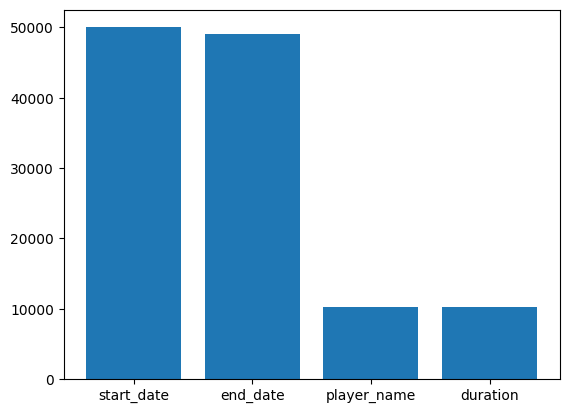

In [57]:
D = check_completeness
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

***
# Boolean columns
These were string 't' and 'f', see: 'check_boolean_columns'


In [58]:
for i in check_boolean_columns:
    count = matches_df_1st_50k[i].count()
    check_boolean_columns[i] += count

In [59]:
print(check_boolean_columns)

{'player_victory': 50000, 'retirement': 50000, 'won_first_set': 49301}


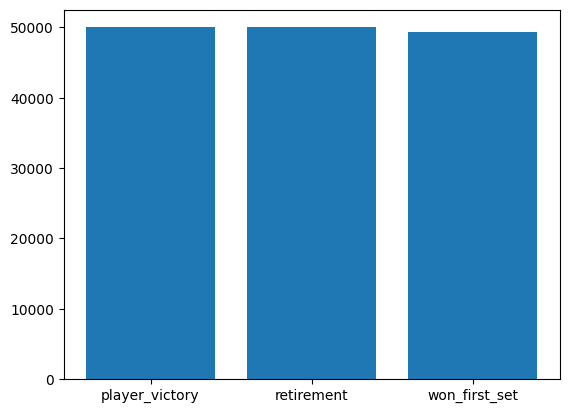

In [60]:
D = check_boolean_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [61]:
for i in check_mixed_columns:
    count = matches_df_1st_50k[i].count()
    check_mixed_columns[i] += count

In [62]:
print(check_mixed_columns)

{'seed': 17926, 'currency': 15537, 'player_name': 10298, 'opponent_name': 10298, 'duration': 10298}


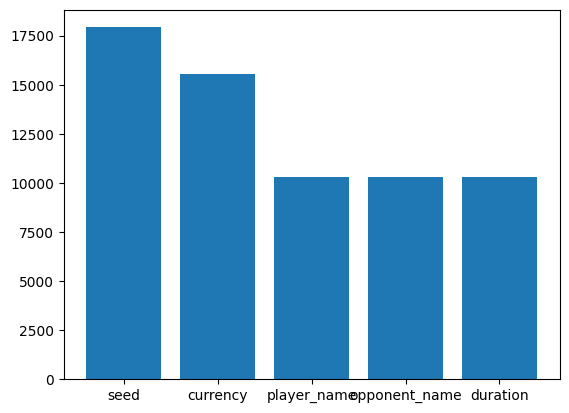

In [63]:
D = check_mixed_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [64]:
for i in check_numerical_columns:
    count = matches_df_1st_50k[i].count()
    check_numerical_columns[i] += count

In [65]:
display(check_numerical_columns)
print(min(check_numerical_columns))
print(max(check_numerical_columns))

{'prize_money': 15537,
 'sets_won': 50000,
 'games_won': 50000,
 'games_against': 50000,
 'tiebreaks_won': 50000,
 'tiebreaks_total': 50000,
 'serve_rating': 10298,
 'aces': 10298,
 'double_faults': 10298,
 'first_serve_made': 10298,
 'first_serve_attempted': 10298,
 'first_serve_points_made': 10298,
 'first_serve_points_attempted': 10298,
 'second_serve_points_made': 10298,
 'second_serve_points_attempted': 10298,
 'break_points_saved': 10298,
 'break_points_against': 10298,
 'service_games_won': 10298,
 'return_rating': 10298,
 'first_serve_return_points_made': 10298,
 'first_serve_return_points_attempted': 10298,
 'second_serve_return_points_made': 10298,
 'second_serve_return_points_attempted': 10298,
 'break_points_made': 10298,
 'break_points_attempted': 10298,
 'return_games_played': 10298,
 'service_points_won': 10298,
 'service_points_attempted': 10298,
 'return_points_won': 10298,
 'return_points_attempted': 10298,
 'total_points_won': 10298,
 'total_points': 10298,
 'duratio

aces
total_points_won


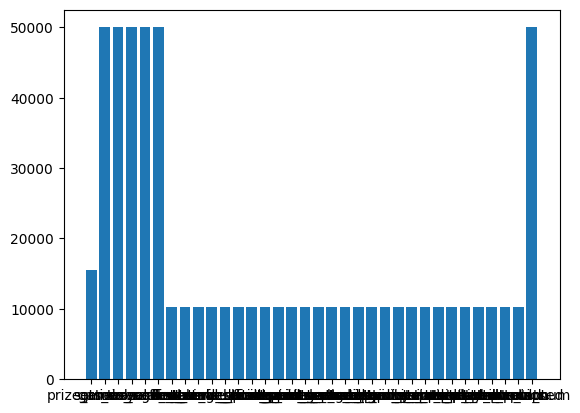

In [66]:
# quick chart to see:
D = check_numerical_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [67]:
for i in check_key_distinguishing_columns:
    count = matches_df_1st_50k[i].count()
    check_key_distinguishing_columns[i] += count

In [68]:
print(check_key_distinguishing_columns)

{'doubles': 50000, 'masters': 50000, 'nation': 50000, 'seed': 17926, 'prize_money': 15537}


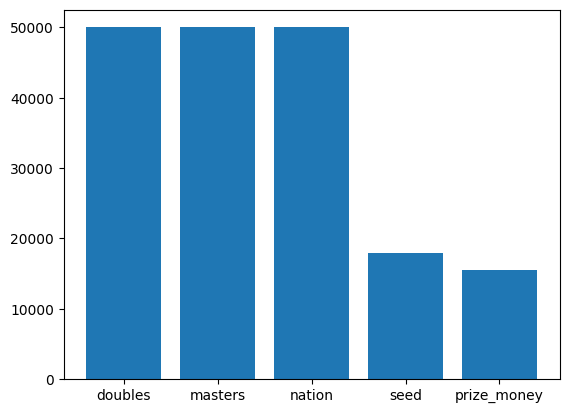

In [69]:
D = check_key_distinguishing_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

***
# Approaches and techniques trialling (for subsequent application in a pipeline)

### 4PIPELINE: RESULT ACCUMULATOR
Operate pipeline with accumulator for any specified result, 
so that memory efficiency is maintained but full dataset checked

### 4PIPELINE: Drop any duplicates

In [70]:
matches_df_1st_50k.drop_duplicates() # shows no duplicates on 1st 50k

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,andrej-martin,...,88.0,01:02:00,f,f,NaN,f,f,100,1,Slovakia
1,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,jozef-kovalik,...,195.0,02:43:00,t,f,NaN,t,f,100,0,Slovakia
2,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti,A. Velotti,dominik-hrbaty,...,126.0,01:17:00,f,f,NaN,f,f,100,3,Slovakia
3,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti_marcel-felder,NaN,andrei-daescu_florin-mergea,...,NaN,NaN,f,f,NaN,t,t,100,4,Slovakia
4,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,...,194.0,02:32:00,t,f,1,t,f,100,3,Slovakia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen,NaN,pablo-figueroa,...,NaN,NaN,f,f,2.0,f,f,25,3,DEN
49996,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andrea-arnaboldi_nicolas-tourte,...,NaN,NaN,t,f,NaN,t,t,25,7,DEN
49997,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andreas-siljestrom_oskar-pallin,...,NaN,NaN,t,f,NaN,t,t,25,6,DEN
49998,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,antti-tuomi_niklas-bucht,...,NaN,NaN,t,f,NaN,t,t,25,4,DEN


### 4PIPELINE: Dropping columns
A: Names: _name column is superflous, can be backfilled to actual names later


In [71]:
# given the repetition of player_ and opponent_ name and id we can drop 2 columns
# 2 checks are needed:
#       1: That the full data repeats the pattern above
#       2: That the ids all match with the all_players csv 
columns_to_drop = ['player_name', 'opponent_name']

In [72]:
# Dealing with the mixed datatypes
print(matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].head())

  currency   player_name  opponent_name  duration seed
0        €      A. Partl      A. Martin  01:02:00  NaN
1        €      A. Partl     J. Kovalik  02:43:00  NaN
2        €    A. Velotti      D. Hrbaty  01:17:00  NaN
3        €           NaN            NaN       NaN  NaN
4        €  A. Giannessi  H. Heliovaara  02:32:00    1


In [73]:
matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].isna().sum()
# on the basis that these numbers are high percentages, all over 60%, some care
# is needed. player_name, opponent_name and duration look to be nearly 80% NA
# 
# will need to confirm this through the rest of the data

currency         34463
player_name      39702
opponent_name    39702
duration         39702
seed             32074
dtype: int64

*** 
# Key data qualities:
## How to best handle and use the issues: 
### 2-rows-represent-one-match

In [74]:
# This is an interesting issue - and provides a relatively substantial problem. 
# 
# Due to the 2 rows representing 1 match, it must be the case that those 2 rows
# are colinear. 

# Colinearity due to 2 row matches: split into 2 win and challenge datasets

In [75]:
# One way to deal with this would be to split into 2 different datasets
# i.e. 
# row X (with the winner data) is in the Winer Dataset
# row X+1 (with the loser data) forms part of the Challenger Dataset
#
# It is not clear this would solve the issue entirely, but certainly a good
# suggestion in the first place.

# CREDIT where due: Neil Robertson from Arup Data Analytics - thanks Neil.



***
# QUERIES TO GET TO SPECIFIC DATA / COLUMNS:
## Contents:
- Filter out columns
- Filter out by column mask, e.g. not doubles

# @@@@@@@@@@@
### Date Filtering:

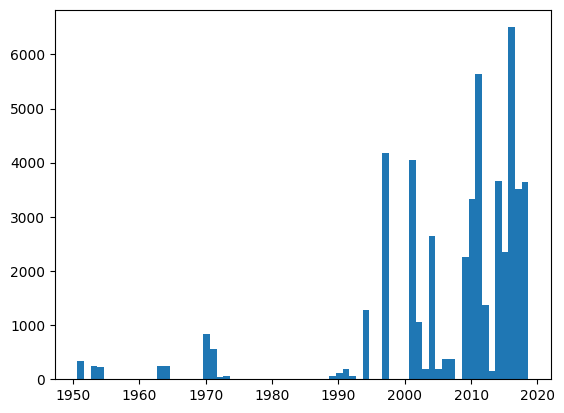

In [76]:
plt.hist(matches_df_1st_50k.start_date,bins=68); # by year

In [77]:
## See chart above - very much weighted to post 2010 
# # with 1st 50k:
#   "start_date > 2018"  RESULTS: 3414 rows => only ~ 1500 matches
#   "start_date > 2010"  RESULTS: 30156 rows => only ~ 15000 matches
matches_df_1st_50k.query("start_date > 2010")

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,andrej-martin,...,88.0,01:02:00,f,f,NaN,f,f,100,1,Slovakia
1,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,jozef-kovalik,...,195.0,02:43:00,t,f,NaN,t,f,100,0,Slovakia
2,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti,A. Velotti,dominik-hrbaty,...,126.0,01:17:00,f,f,NaN,f,f,100,3,Slovakia
3,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti_marcel-felder,NaN,andrei-daescu_florin-mergea,...,NaN,NaN,f,f,NaN,t,t,100,4,Slovakia
4,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,...,194.0,02:32:00,t,f,1,t,f,100,3,Slovakia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49708,2010-09-27,2010-10-03,POR,Clay,NaN,NaN,2010,vitor-silva,NaN,diogo-cabral,...,NaN,NaN,t,f,NaN,t,f,25,0,POR
49709,2010-09-27,2010-10-03,POR,Clay,NaN,NaN,2010,vitor-silva,NaN,stephan-fransen,...,NaN,NaN,f,f,NaN,f,f,25,1,POR
49710,2010-09-27,2010-10-03,POR,Clay,NaN,NaN,2010,wesley-koolhof,NaN,goncalo-falcao,...,NaN,NaN,t,f,NaN,t,f,25,3,POR
49711,2010-09-27,2010-10-03,POR,Clay,NaN,NaN,2010,wesley-koolhof,NaN,laurent-rochette,...,NaN,NaN,f,f,NaN,t,f,25,4,POR


### Given these results, simply must do a similar check for the full dataset - 30k is a decent but nothing substantial dataset

In [22]:
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

In [23]:
matches_df_1st_50k.head()

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,andrej-martin,...,88.0,01:02:00,f,f,NaN,f,f,100,1,Slovakia
1,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,adrian-partl,A. Partl,jozef-kovalik,...,195.0,02:43:00,t,f,NaN,t,f,100,0,Slovakia
2,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti,A. Velotti,dominik-hrbaty,...,126.0,01:17:00,f,f,NaN,f,f,100,3,Slovakia
3,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,agustin-velotti_marcel-felder,NaN,andrei-daescu_florin-mergea,...,NaN,NaN,f,f,NaN,t,t,100,4,Slovakia
4,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,...,194.0,02:32:00,t,f,1,t,f,100,3,Slovakia


***
# First go through the FULL dataset

## Functions for data trawl

In [113]:
def check_through_count(dataframe, dict_to_check):
    for i in dict_to_check.keys():
        count = dataframe[i].count()
        dict_to_check[i] += count
    return dict_to_check

In [114]:
# na_checks
# round((matches_df_1st_50k.seed.isna().sum()/50_000)*100,2)

def na_count(dataframe, dict_to_check):
    for i in dict_to_check.keys():
        dict_to_check[i] += dataframe[i].isna().sum()
    return dict_to_check

In [115]:
def count_by_date(dataframe, date_query_dict):
    for i in date_query_dict.keys():
        query_count = dataframe.query(i)
        # display(len(query_count))
        date_query_dict[i] += len(query_count)
    return date_query_dict


In [116]:
# round((matches_df_1st_50k.seed.isna().sum()/50_000)*100,2)

In [117]:
path = read_data_path
def get_count_csvs(path):
    csv_files = []
    file_list = os.listdir(path)
    for i in file_list:
        if ".csv" in i:
            csv_files.append(os.path.join(path,i))
    return csv_files

In [20]:
run_through_hefty_EDA_cells = 1

In [24]:
# to go through all the sample data set
if run_through_hefty_EDA_cells:
    
    start = time.time()
    ave_bytes = 0
    count = 0
    total_bytes = 0

    # this works to convert dates as reading in. good news
    schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}

    csv_files = get_count_csvs(read_data_path)          
    if len(csv_files) == 0:
        chunk_count = 0
        # This enumerate function selects repeated chunks of XXX rows of data 
        for index, read_chunk in enumerate(pd.read_csv(matches_data_path_full
                                                    , chunksize= 100_000
                                                    # usecols = list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                                    #, parse_dates=True
                                                    ),
                                            start=1):
            chunk_count += 100_000
            print(f"{index} so done with {chunk_count}")
            # output
            output_path = os.path.join(read_data_path,f"read_data_{index}.csv")
            read_chunk.to_csv(output_path, index=False)
        
    csv_files = get_count_csvs(read_data_path) # get the files now created
    for index, csv in enumerate(csv_files): # read back in in manageable quantities, with astype etc
        chunk = pd.read_csv(csv, index_col=None).astype(schema)
        this_bytes = chunk.memory_usage().sum()
        total_bytes += this_bytes
        # count data points and accumulate in the various dicts
        check_completeness = check_through_count(chunk, check_completeness)
        check_key_distinguishing_columns = check_through_count(chunk, check_key_distinguishing_columns)
        check_numerical_columns = check_through_count(chunk, check_numerical_columns)
        check_mixed_columns = check_through_count(chunk, check_mixed_columns)
        check_boolean_columns = check_through_count(chunk, check_boolean_columns)
        date_query_result = count_by_date(chunk, single_date_query)
        na_check = na_count(chunk, na_checks)

    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
    ave_bytes = total_bytes / index
    print(f"Average MB per loop: {round(ave_bytes/100_000,0):,}")
    print(check_completeness)

    print(round(time.time() - start,2), ' seconds')

    # Total number of chunks: 43 ______________________ of 100_000 rows
    # Total memory, MB: 18,558.0
    # Average MB per loop: 432.0
    # {'start_date': 4395827, 'end_date': 4295393, 'player_name': 375001, 'duration': 372823}
    # 72.15  seconds

/tmp/ipykernel_51826/762402661.py:30: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None).astype(schema)
/tmp/ipykernel_51826/762402661.py:30: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None).astype(schema)
/tmp/ipykernel_51826/762402661.py:30: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None).astype(schema)
/tmp/ipykernel_51826/762402661.py:30: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None).astype(schema)
/tmp/ipykernel_51826/762402661.py:30: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=N

Total number of chunks: 42
Total memory, MB: 0.0
Average MB per loop: 442.0
{'start_date': 4295827, 'end_date': 4197459, 'player_name': 354405, 'duration': 352227}
88.96  seconds


In [26]:
# date_query_result >>> printed: {'start_date > 2010': 1786877}
#
# so at least 1.7m rows (so 835_000 matches have a start date after 2010)
# this is the likely maximum that can be relied on as recent matches. 
# obviously all the other columns, especially the numerical ones will be 
# relevant.
# 
# NEXT QUESTION BEING: 
#                     What proportion of >2010 matches have all numerical 
#                     columns?
display(date_query_result)
display(na_check)

# RESULTS:
# ### NOTE Somehow all these numbers change...

# {'start_date > 2010': 1812529} 

# {'seed': 2872204,
#  'serve_rating': 3984126,
#  'aces': 3984126,
#  'double_faults': 3984126,
#  'first_serve_made': 3984126,
#  'first_serve_attempted': 3984126,
#  'first_serve_points_made': 3984126}

# now need to run queries for post 2010 in those columns:

# going to be a lot of running queries, functions etc and running through...

{'start_date > 2010': 1786877}

{'seed': 2848479,
 'serve_rating': 3943594,
 'aces': 3943594,
 'double_faults': 3943594,
 'first_serve_made': 3943594,
 'first_serve_attempted': 3943594,
 'first_serve_points_made': 3943594}

{'doubles': 4295827,
 'masters': 4295827,
 'nation': 4295827,
 'seed': 1447348,
 'prize_money': 786890}

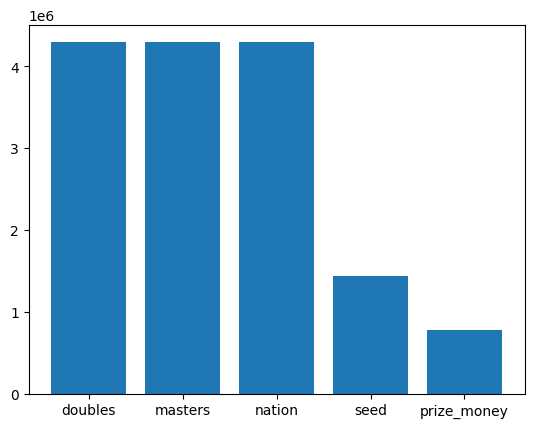

In [25]:
# check_completeness check_boolean_columns check_mixed_columns 
# check_numerical_columns check_key_distinguishing_columns
D = check_key_distinguishing_columns
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

{'player_victory': 4293439, 'retirement': 4288611, 'won_first_set': 4231342}

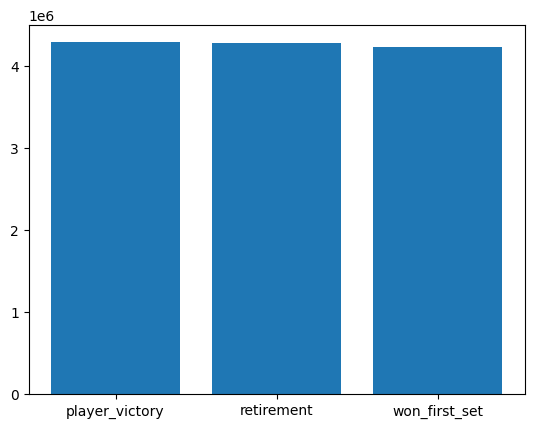

In [27]:
# check_completeness check_boolean_columns check_mixed_columns 
# check_numerical_columns check_key_distinguishing_columns
D = check_boolean_columns
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

{'seed': 1447348,
 'currency': 786890,
 'player_name': 354405,
 'opponent_name': 354405,
 'duration': 352227}

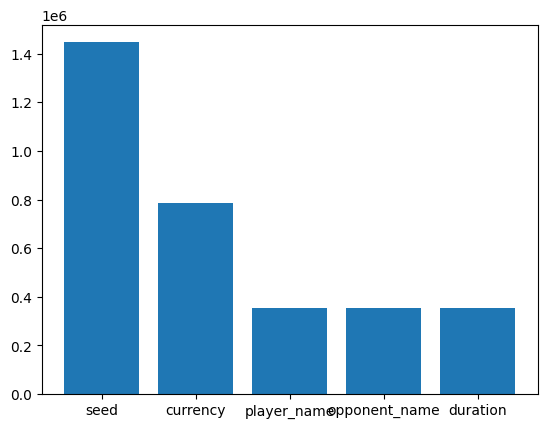

In [28]:
# check_completeness check_boolean_columns check_mixed_columns 
# check_numerical_columns check_key_distinguishing_columns
D = check_mixed_columns
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

{'prize_money': 786890,
 'sets_won': 4293439,
 'games_won': 4293439,
 'games_against': 4293439,
 'tiebreaks_won': 4293439,
 'tiebreaks_total': 4293439,
 'serve_rating': 352233,
 'aces': 352233,
 'double_faults': 352233,
 'first_serve_made': 352233,
 'first_serve_attempted': 352233,
 'first_serve_points_made': 352233,
 'first_serve_points_attempted': 352233,
 'second_serve_points_made': 352233,
 'second_serve_points_attempted': 352233,
 'break_points_saved': 352233,
 'break_points_against': 352233,
 'service_games_won': 352233,
 'return_rating': 352233,
 'first_serve_return_points_made': 352233,
 'first_serve_return_points_attempted': 352233,
 'second_serve_return_points_made': 352233,
 'second_serve_return_points_attempted': 352233,
 'break_points_made': 352233,
 'break_points_attempted': 352233,
 'return_games_played': 352233,
 'service_points_won': 352233,
 'service_points_attempted': 352233,
 'return_points_won': 352233,
 'return_points_attempted': 352233,
 'total_points_won': 35223

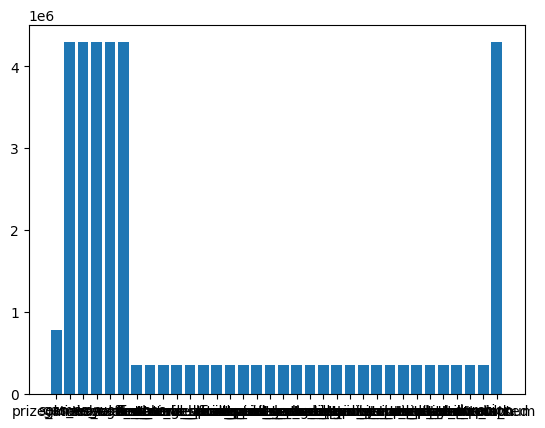

In [41]:
# check_completeness check_boolean_columns check_mixed_columns 
# check_numerical_columns check_key_distinguishing_columns
D = check_numerical_columns
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [45]:
check_numerical_columns.keys()

dict_keys(['prize_money', 'sets_won', 'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total', 'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 'service_games_won', 'return_rating', 'first_serve_return_points_made', 'first_serve_return_points_attempted', 'second_serve_return_points_made', 'second_serve_return_points_attempted', 'break_points_made', 'break_points_attempted', 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 'return_points_attempted', 'total_points_won', 'total_points', 'duration', 'round_num'])

In [46]:
subset_1st_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'prize_money','sets_won','games_won',  
                           'games_against','tiebreaks_won','tiebreaks_total','round_num'}}
subset_2nd_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 
                                                                                                 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 
                                                                                                 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 
                                                                                                 'service_games_won', 'return_rating', 'first_serve_return_points_made', 
                                                                                                 'second_serve_return_points_attempted', 'first_serve_return_points_attempted', 
                                                                                                 'second_serve_return_points_made', 'break_points_made', 'break_points_attempted', 
                                                                                                 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 
                                                                                                 'return_points_attempted', 'total_points_won', 'total_points', 'duration'}}

{'round_num': 4295827,
 'sets_won': 4293439,
 'prize_money': 786890,
 'tiebreaks_won': 4293439,
 'games_against': 4293439,
 'games_won': 4293439,
 'tiebreaks_total': 4293439}

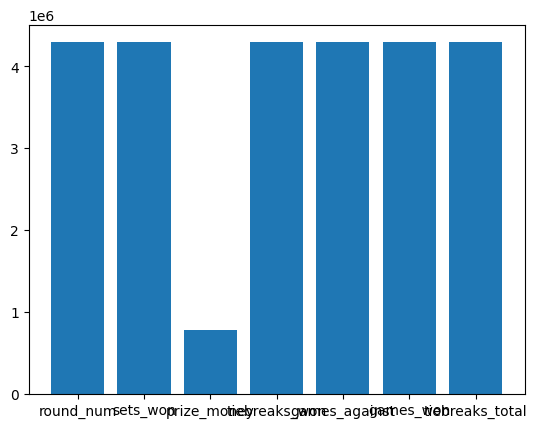

In [44]:
D = subset_1st_numerical
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

{'return_points_attempted': 352233,
 'service_games_won': 352233,
 'total_points_won': 352233,
 'double_faults': 352233,
 'return_rating': 352233,
 'return_games_played': 352233,
 'first_serve_points_attempted': 352233,
 'service_points_attempted': 352233,
 'service_points_won': 352233,
 'break_points_saved': 352233,
 'first_serve_attempted': 352233,
 'total_points': 352233,
 'first_serve_points_made': 352233,
 'first_serve_return_points_made': 352233,
 'break_points_against': 352233,
 'first_serve_return_points_attempted': 352233,
 'break_points_made': 352233,
 'duration': 352227,
 'serve_rating': 352233,
 'second_serve_points_made': 352233,
 'aces': 352233,
 'second_serve_return_points_attempted': 352233,
 'first_serve_made': 352233,
 'second_serve_points_attempted': 352233,
 'second_serve_return_points_made': 352233,
 'break_points_attempted': 352233,
 'return_points_won': 352233}

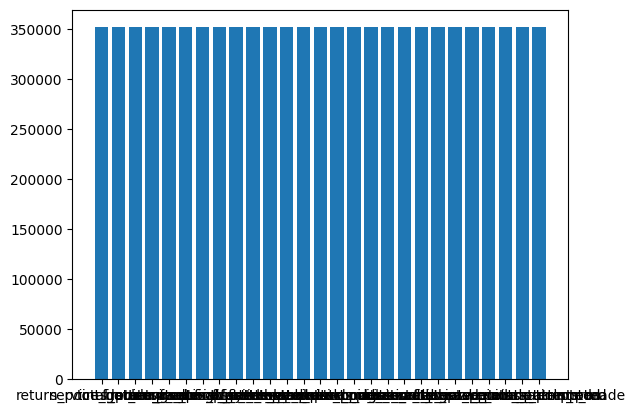

In [49]:
D = subset_2nd_numerical
display(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));


## LIMIT OF THE USEFUL DATA HERE??? 352233 rows

In [ ]:
# subset_2nd_numerical might be the limit of the useful data. 
print(len(subset_2nd_numerical.keys()))
# all have 352233 data points, bar duration: 352227

# subset_1st_numerical is quite different, and has 4.29M data points for
# most except prize_money @ 786k

## Try to convert datatypes on loading data into Pandas
- This fails, see below (and heavy computational cell skipped)
- Column is not a single type, so conversion isn't simple

In [ ]:
types = defaultdict(str, aces=int, currency=float)
# df = pd.read_csv("/path/to/file.csv", dtype=types, keep_default_na=False)
col_dtype_changes = {'location': str, 'aces': float} # 'start_date': np.datetime64, 'end_date': np.datetime64, 

In [ ]:
# now to adjust the datatypes as each chunk is loaded:
# BUT
# dtype conversions fail as empty cells etc - skip cell for now
skip_cell = 1

if not skip_cell: 
    start = time.time()
    ave_bytes = 0
    count = 0
    total_bytes = 0
    header = True
    # This enumerate function selects repeated chunks of 1,000,000 rows of data 
    for index, chunk in enumerate(pd.read_csv(matches_data_path_full 
                                                , chunksize= 100_000
                                                , usecols = ['aces'] # list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                                , dtype=col_dtype_changes # types
                                                , parse_dates=True
                                                , keep_default_na=False),
                                start=1):
        this_bytes = chunk.memory_usage().sum()
        ave_bytes += this_bytes
        total_bytes = total_bytes + this_bytes
        # This inner loop iterates through the rate keys only.Then it does 
        # vectorised selections on the dataframe to select count of each rate key.
        for i in check_completeness:
            count = chunk[i].count()
            check_completeness[i] += count
            
        for i in check_boolean_columns:
            count = chunk[i].count()
            check_boolean_columns[i] += count

    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
    ave_bytes = ave_bytes / index
    print(f"Average bytes per loop: {round(ave_bytes/100_000,0):,}")
    print(check_completeness)

    print(round(time.time() - start,2), ' seconds')

## See above, an attempt to convert data types on load fails
    This is because there are >1 datatypes in a single column, e.g. 'aces' which has at least: float, str

In [ ]:
# when done with data processing, save back to single file with mode="a" 
# header = True
# for chunk in chunks:

#     chunk.to_csv(os.path.join(folder, new_folder, "new_file_" + filename),
#         header=header, cols=[['TIME','STUFF']], mode='a')

#     header = False

***
NOTE - using 1st 50k to establish methods, copying across here to ensure future compatability.
@ DON'T FORGET!
***

In [ ]:
matches_df = matches_df_1st_50k

In [ ]:
matches_column_names = matches_df.columns
matches_column_names

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

In [ ]:
matches_dtypes = matches_df.dtypes
matches_df_objects = matches_dtypes[matches_dtypes==object]
matches_df_objects = pd.DataFrame(matches_df_objects).reset_index()
matches_df_objects.rename(columns={'index': 'column_name', 0: 'dtype'}, inplace=True)
print(matches_df_objects.columns)
matches_df_objects

Index(['column_name', 'dtype'], dtype='object')


,column_name,dtype
0,location,object
1,court_surface,object
2,currency,object
3,player_id,object
4,player_name,object
5,opponent_id,object
6,opponent_name,object
7,tournament,object
8,round,object
9,duration,object


In [ ]:
matches_date_columns = matches_df_objects[:2]
matches_date_columns

,column_name,dtype
0,location,object
1,court_surface,object


In [ ]:
middle_cols = matches_df[matches_df.columns[12:20]]
middle_cols

,round,num_sets,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating
0,2nd Round Qualifying,2,0,3,12,0,0,149.0
1,1st Round Qualifying,3,2,16,12,0,0,249.0
2,Round of 32,2,0,7,12,0,0,225.0
3,Round of 16,3,1,18,22,1,1,NaN
4,Round of 32,3,2,17,15,1,1,276.0
...,...,...,...,...,...,...,...,...
49995,Round of 32,2,0,7,12,0,0,NaN
49996,Finals,2,2,12,3,0,0,NaN
49997,Semi-Finals,2,2,12,7,0,0,NaN
49998,Round of 16,2,2,12,6,0,0,NaN


# Polars

In [ ]:
# ! pip install polars
# import polars as pl # this will not work on my machine

!pip install polars-lts-cpu
import polars as pl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 18.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [ ]:
# this crashes, too big 890mb => skip_cell
# need to work on getting polars operational - or just use chunk_size equivalent
skip_cell = 1
if not skip_cell:
    matches_csv_file = '../raw_data/archive/all_matches.csv'
    # matches_df_polar = pl.read_csv()
    # matches_df_polar = pl.read_csv_batched(matches_csv_file)
    reader = pl.read_csv_batched(

        matches_csv_file,

        try_parse_dates=True,

    )  

    batches = reader.next_batches(5)  

    for df in batches:  

        print(df)
    


In [ ]:
df.dtypes.head()

In [ ]:
len(df.columns)

***
# RUN HERE: Get first sample of the full dataset to ease usage

## trawl through archive and get samples out
### currently set to 10k per each of 43 => 430k rows

In [129]:
sample_df_path = os.path.join('..','raw_data','atp_sample.csv')
sample_post_2010_df_path = os.path.join('..','raw_data','atp_sample_post_2010.csv')

get_data_sample_from_43 = 1 # set to zero as won't need to run this EVERY time.
n_samples = 5_000 # was 10k but not >10k post 2010 rows in each 100_000 csv...

In [130]:
sample_only_from_post_2010 = 1

In [132]:
# trawl through, get sample. different every time, will hopefully be random enough
if get_data_sample_from_43:
    accumulator_df = pd.DataFrame() # empty
    start = time.time()
    ave_bytes = 0
    count = 0
    total_bytes = 0
    # this works to convert dates as reading in. good news
    schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
       
    csv_files = get_count_csvs(read_data_path) # get the files now created
    assert len(csv_files) > 0, "ERROR: need to get .csv files from archive, see above"
    
    for index, csv in enumerate(csv_files):
        # read back in in manageable quantities, with astype etc
        chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
        # clock memory usage:
        this_bytes = chunk.memory_usage().sum()
        ave_bytes += this_bytes
        total_bytes = total_bytes + this_bytes

        # get sample:
        if sample_only_from_post_2010:
            chunk['year'] = chunk['year'].astype(int)
            count_of_post_2010 = len(chunk.query(list(single_year_query.keys())[0]))
            if count_of_post_2010 < n_samples:
                # then we have an issue with post 2010 data. 
                print(f"csv {csv} had only {count_of_post_2010} post 2010 rows: skipping sampling")
            else:
                new_sample = chunk.query(list(single_year_query.keys())[0]).sample(n_samples)
                accumulator_df = pd.concat((accumulator_df, new_sample), axis=0)
        else:
            new_sample = chunk.sample(n_samples)
            accumulator_df = pd.concat((accumulator_df, new_sample), axis=0)

    print(f"len(accumulator_df): {len(accumulator_df)} {len(csv_files)}*{n_samples} = {len(csv_files)*n_samples}")
    print(f"accumulator_df.shape: {accumulator_df.shape}")
    
    accumulator_df.reset_index()
    
    if sample_only_from_post_2010:
        accumulator_df.to_csv(sample_post_2010_df_path)
    else:
        accumulator_df.to_csv(sample_df_path)

    bytes_per_mb = 100_000
    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/bytes_per_mb,0):,}")
    ave_bytes = ave_bytes / index
    print(f"Average MB per loop: {round(ave_bytes/bytes_per_mb,0):,}")

    print(round(time.time() - start,2), ' seconds')

/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)


csv ../raw_data/read_data/read_data_40.csv had only 1430 post 2010 rows: skipping sampling


/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.rea

csv ../raw_data/read_data/read_data_42.csv had only 1294 post 2010 rows: skipping sampling
csv ../raw_data/read_data/read_data_43.csv had only 0 post 2010 rows: skipping sampling


/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)


csv ../raw_data/read_data/read_data_41.csv had only 2274 post 2010 rows: skipping sampling


/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
/tmp/ipykernel_30476/3117755195.py:16: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(csv, index_col=None) # .astype(schema)


len(accumulator_df): 195000 43*5000 = 215000
accumulator_df.shape: (195000, 54)
Total number of chunks: 42
Total memory, MB: 18,558.0
Average MB per loop: 442.0
86.73  seconds


## Load from sample:

In [41]:
if not 'accumulator_df' in locals(): # load from csv:
    atp_sample = pd.read_csv(sample_df_path, index_col=None).astype(schema)
    atp_sample = atp_sample.drop(columns=['Unnamed: 0']) # would be nice to be clear on how to avoid this...
else: 
    atp_sample = accumulator_df
print(atp_sample.shape)
atp_sample.head(5)

(430000, 54)


,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,1999-03-26,1999-04-25,USA,Hard,NaN,NaN,1999,mathias-schwarzler_ronald-dueller,NaN,alexander-reichel_grant-doyle,...,NaN,NaN,f,f,NaN,t,t,25,4,USA
1,2012-11-19,2012-11-24,MEX,Hard,NaN,NaN,2012,chi-shan-jao,NaN,hugo-di-feo,...,NaN,NaN,f,f,NaN,f,f,0,3,MEX
2,1993-11-06,1993-12-05,PAR,Clay,NaN,NaN,1993,hector-moretti,NaN,pablo-minutella,...,NaN,NaN,t,f,3,t,f,25,3,PAR
3,2014-08-25,2014-08-31,CRO,Clay,NaN,NaN,2014,gregor-hutterer_peter-heller,NaN,ivan-sabanov_matej-sabanov,...,NaN,NaN,f,f,3,t,t,25,5,CRO
4,1994-03-26,1994-04-23,MAR,Clay,NaN,NaN,1994,rene-hanak,NaN,mehdi-tahiri,...,NaN,NaN,f,f,6,f,f,25,4,MAR


*** 
# Pipeline
***
***

In [44]:
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
date_schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
new_date_schema = {0: "datetime64[ns]", 1: "datetime64[ns]"}

In [45]:
[col for col in atp_sample.columns if col in date_schema]

['start_date', 'end_date']

In [61]:
# lists for transformers, pipelines and associated functions:
new_numerical_columns = list(atp_sample.select_dtypes(include=[np.number]).columns.values)
remove_cols = ['year', 'masters', 'round_num', 'prize_money']
for c in remove_cols:
    if c in new_numerical_columns:
        new_numerical_columns.remove(c)
other_num_columns = remove_cols

In [62]:
new_numerical_columns

['num_sets',
 'sets_won',
 'games_won',
 'games_against',
 'tiebreaks_won',
 'tiebreaks_total',
 'serve_rating',
 'aces',
 'double_faults',
 'first_serve_made',
 'first_serve_attempted',
 'first_serve_points_made',
 'first_serve_points_attempted',
 'second_serve_points_made',
 'second_serve_points_attempted',
 'break_points_saved',
 'break_points_against',
 'service_games_won',
 'return_rating',
 'first_serve_return_points_made',
 'first_serve_return_points_attempted',
 'second_serve_return_points_made',
 'second_serve_return_points_attempted',
 'break_points_made',
 'break_points_attempted',
 'return_games_played',
 'service_points_won',
 'service_points_attempted',
 'return_points_won',
 'return_points_attempted',
 'total_points_won',
 'total_points']

In [63]:
first_subset_num = ['num_sets',
 'sets_won',
 'games_won',
 'games_against',
 'tiebreaks_won',
 'tiebreaks_total',
 'serve_rating',
 'aces',
 'double_faults',
 'first_serve_made',
 'first_serve_attempted',
 'first_serve_points_made',
 'first_serve_points_attempted',
 'second_serve_points_made',
 'second_serve_points_attempted',
 'break_points_saved',
 'break_points_against',
 'service_games_won']

In [103]:
print(len(new_numerical_columns))
print(len(first_subset_num))
second_subset_num = [col for col in new_numerical_columns if col not in first_subset_num]
print(len(second_subset_num))

32
18
14


In [104]:
second_subset_num

['return_rating',
 'first_serve_return_points_made',
 'first_serve_return_points_attempted',
 'second_serve_return_points_made',
 'second_serve_return_points_attempted',
 'break_points_made',
 'break_points_attempted',
 'return_games_played',
 'service_points_won',
 'service_points_attempted',
 'return_points_won',
 'return_points_attempted',
 'total_points_won',
 'total_points']

## Look through numerical columns, count NAs:

In [105]:
first_num_NAs = []
for c in first_subset_num:
    first_num_NAs.append(atp_sample[c].isna().sum())

second_num_NAs = []
for c in second_subset_num:
    second_num_NAs.append(atp_sample[c].isna().sum())

['num_sets', 'sets_won', 'games_won', 'games_against', 'tiebreaks_won']


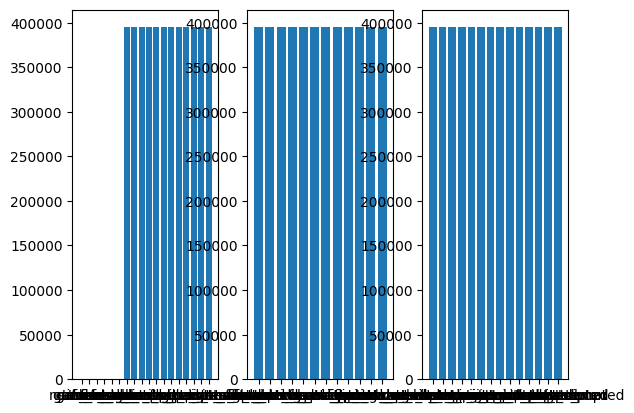

In [109]:
figure, axis = plt.subplots(1, 3) 
axis[0].bar(first_subset_num, first_num_NAs)
axis[1].bar(first_subset_num[6:], first_num_NAs[6:])
axis[2].bar(second_subset_num[:], second_num_NAs[:])

print(first_subset_num[0:5]) # these columns are the only numerical columsn without massive majority NA's

### Gather columns for preprocessing

In [43]:
atp_sample.dtypes

start_date                              datetime64[ns]
end_date                                datetime64[ns]
location                                        object
court_surface                                   object
prize_money                                    float64
currency                                        object
year                                             int64
player_id                                       object
player_name                                     object
opponent_id                                     object
opponent_name                                   object
tournament                                      object
round                                           object
num_sets                                       float64
sets_won                                       float64
games_won                                      float64
games_against                                  float64
tiebreaks_won                                  float64
tiebreaks_

## Still thinking to be done: Lots of NAs in numerical columns - how should we treat these?

In [58]:
atp_sample[second_subset_num].head(1)

,return_rating,first_serve_return_points_made,first_serve_return_points_attempted,second_serve_return_points_made,second_serve_return_points_attempted,break_points_made,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,masters,round_num
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,4


In [50]:
print(len(new_numerical_columns))
print(len(first_subset_num))
second_subset_num = [col for col in new_numerical_columns if col not in first_subset_num]
print(len(second_subset_num))


35
19
16


### Functions for transformers and pipelines:

In [505]:
# functions for transformers and pipelines:
def convert_dates(df):
    return df.apply(lambda x: x.astype(dtype="datetime64[ns]"))

def get_custom_feature_names(transformer, feature_names):
    return [f'{col}' for col in feature_names]

datetime_transformer = Pipeline(steps=[
    ('date_converter', FunctionTransformer(convert_dates, feature_names_out=get_custom_feature_names, validate=False))
])

# Custom column selector function
def custom_date_column_selector():
    def selector_from_date_schema(df):
        return [col for col in atp_sample.columns if col in date_schema]
    return selector_from_date_schema

# custom numerical
def custom_num_column_selector():
    def selector_from_num_schema(df):
        return [col for col in atp_sample.columns if col in first_subset_num]
    return selector_from_num_schema

type_changer = FunctionTransformer(lambda array: pd.DataFrame.astype(array,dtype=np.number), 
                                   feature_names_out=get_custom_feature_names)

# from LW#900
rounder = FunctionTransformer(lambda array: np.round(array, decimals=2), 
                                feature_names_out=get_custom_feature_names)


# from LW#900:
# makeVolumeTransformer = FunctionTransformer(lambda array: pd.DataFrame(array['product_length_cm']*array['product_height_cm']*array['product_width_cm']))

# TRY THIS:
# datetime_transformer = FunctionTransformer(lambda array: pd.DataFrame(array.astype(dtype="datetime64[ns]")))


### Transformers and pipelines:

In [506]:
# Define the datetime transformer, exchange with whichever you pefer

# NOTES num_transformer => looking to impute all NAN values. somewhat aggressive!
#       In general: Impute then scale numerical values:
num_transformer = Pipeline([
    # ('type_changer', type_changer), # this is likely misfunctioning
    ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value=0)),
    ('standard_scaler', StandardScaler()),
    # ('rounder', rounder)
])

# NOTES seed_transformer => sometimes seed column is given as 'SE' 
#       there might be other values too, can probably deal with these as:
seed_transformer = Pipeline([
    ('seed1', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value=0)), 
    ('seed2', SimpleImputer(strategy='constant', missing_values="SE", fill_value=0)), # ASSUMPTION that SE in Seed column can be set to zero. CHECK ASSUMPTION
])



### Preprocessor:

In [ ]:

# Create preprocessor with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('dt', datetime_transformer, ['start_date', 'end_date', 'year']), # [or just list of column names] # custom_date_column_selector()
        ('num', num_transformer, custom_num_column_selector()), 
        # assume that no seeding can be suitable set by 0, without causing trouble
        ('seed', seed_transformer, ['seed']), 

        # ('cat', OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=object)),
        
    ],remainder='passthrough'
    )

In [507]:
preprocessor # check preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('dt',
                                 Pipeline(steps=[('date_converter',
                                                  FunctionTransformer(feature_names_out=<function get_custom_feature_names at 0x798967952170>,
                                                                      func=<function convert_dates at 0x798967950430>))]),
                                 ['start_date', 'end_date', 'year']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 <function custom_num_column_selector.<locals>.selector_from_num_schema at 0x798967b970a0>),
                                ('seed',
                                 Pipeline(steps=[('seed1',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('seed2',
                                                  SimpleImputer(fill_value=0,
                                                                missing_values='SE',
                                                                strategy='constant'))]),
                                 ['seed'])])

### Pipeline

In [508]:
# Build the pipeline with the different steps
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

### Pipeline readying:

In [509]:
atp_sample[['year', 'seed', 'start_date', 'end_date']].head(2)

,year,seed,start_date,end_date
20638,1993,NaN,1993-11-06,1993-12-05
60684,2001,1,2001-08-27,2001-09-23


In [510]:
str_check = atp_sample.astype(str)
str_check[str_check['seed'].str.contains("SE|se")==True]

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
19416,2014-06-30,2014-07-06,Germany,Clay,106500.0,€,2014,nikola-cacic,N. Cacic,pablo-carreno-busta,...,191.0,02:02:00,t,f,SE,t,f,100,3,Germany


### Pipeline usage

In [511]:
atp_transformed = pipeline.fit_transform(atp_sample[['year', 'seed', *new_numerical_columns, 'start_date', 'end_date']]) 

In [ ]:
# convert back into dataframe, with (updated) column headings
atp_again = pd.DataFrame(
    atp_transformed,
    columns=preprocessor.get_feature_names_out()
).convert_dtypes().head()

### Pipeline results

In [480]:
atp_again

,dt__start_date,dt__end_date,dt__year,num__total_points,seed__seed,remainder__prize_money,remainder__num_sets,remainder__sets_won,remainder__games_won,remainder__games_against,...,remainder__break_points_made,remainder__break_points_attempted,remainder__return_games_played,remainder__service_points_won,remainder__service_points_attempted,remainder__return_points_won,remainder__return_points_attempted,remainder__total_points_won,remainder__masters,remainder__round_num
0,752544000000000000,755049600000000000,1993,-0.28,0,<NA>,3,2,17,13,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25,0
1,998870400000000000,1001203200000000000,2001,-0.28,1,<NA>,3,2,17,14,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25,4
2,1000080000000000000,1000598400000000000,2001,-0.28,0,<NA>,2,0,7,12,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25,3
3,750124800000000000,752544000000000000,1993,-0.28,8,<NA>,2,0,2,12,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25,5
4,999475200000000000,999820800000000000,2001,-0.28,0,<NA>,3,1,14,13,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25,0


In [461]:
str_check = atp_again.astype(str)
str_check[str_check['seed1__seed'].str.contains("SE|se")==True]

,dt__start_date,dt__end_date,num__total_points,seed1__seed,remainder__year


In [368]:
# new schema:
post_process_1_date_schema = {"dt__start_date": "datetime64[ns]", "dt__end_date": "datetime64[ns]"}
post_process_1_numerical_columns = list(atp_sample.select_dtypes(include=[np.number]).columns.values)

In [513]:
atp_again = pd.DataFrame(atp_again).astype(post_process_1_date_schema)

In [516]:
display(atp_again.dtypes.head(15))

dt__start_date                datetime64[ns]
dt__end_date                  datetime64[ns]
dt__year                               Int64
num__prize_money                     Float64
num__num_sets                         object
num__sets_won                          Int64
num__games_won                         Int64
num__games_against                     Int64
num__tiebreaks_won                     Int64
num__tiebreaks_total                   Int64
num__serve_rating                      Int64
num__aces                              Int64
num__double_faults                     Int64
num__first_serve_made                  Int64
num__first_serve_attempted             Int64
dtype: object

In [17]:
atp_again

NameError: name 'atp_again' is not defined